In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"../data/df_dummies.csv")
features = pd.read_csv(r"../data/features.csv")
target = pd.read_csv(r"../data/target.csv")

results = {}

In [3]:
target_series = target.squeeze()

## KNN


In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8)

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test) 
y_pred_knn

knn.score(X_test, y_test) 

knn_accuracy = accuracy_score(y_test, y_pred_knn)
results['KNN'] = knn_accuracy
print(f'Accuracy del modelo de KNN: {knn_accuracy:.2f}')

Accuracy del modelo de KNN: 0.74


In [5]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

     Average       0.58      0.73      0.65       354
        High       0.64      0.56      0.60       200
         Low       0.87      0.80      0.83       790

    accuracy                           0.74      1344
   macro avg       0.70      0.70      0.69      1344
weighted avg       0.76      0.74      0.75      1344



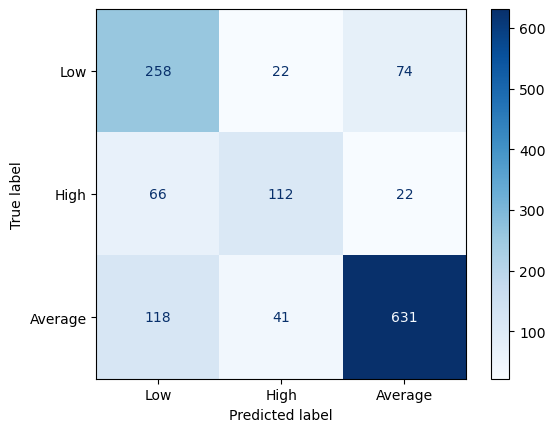

In [6]:
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Bagging and Pasting

In [7]:
# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Bagging con DecisionTreeClassifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                   n_estimators=100, 
                                   random_state=42)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_bagging = bagging_model.predict(X_test)

# Evaluar el modelo
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f'Accuracy del modelo de Bagging: {bagging_accuracy:.2f}')

# Pasting con DecisionTreeClassifier
pasting_model = BaggingClassifier(estimator=DecisionTreeClassifier(), 
                                   n_estimators=100, 
                                   bootstrap=False,  # Sin reemplazo
                                   random_state=42)

# Entrenar el modelo
pasting_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_pasting = pasting_model.predict(X_test)

# Evaluar el modelo
pasting_accuracy = accuracy_score(y_test, y_pred_pasting)
results['Bagging and Pasting'] = pasting_accuracy
print(f'Accuracy del modelo de Pasting: {pasting_accuracy:.2f}')

Accuracy del modelo de Bagging: 0.77
Accuracy del modelo de Pasting: 0.76


In [8]:
print(classification_report(y_test, y_pred_bagging))

              precision    recall  f1-score   support

     Average       0.64      0.68      0.66       354
        High       0.63      0.63      0.63       200
         Low       0.88      0.85      0.87       790

    accuracy                           0.77      1344
   macro avg       0.71      0.72      0.72      1344
weighted avg       0.78      0.77      0.78      1344



In [9]:
print(classification_report(y_test, y_pred_pasting))

              precision    recall  f1-score   support

     Average       0.63      0.62      0.62       354
        High       0.55      0.60      0.58       200
         Low       0.88      0.86      0.87       790

    accuracy                           0.76      1344
   macro avg       0.69      0.69      0.69      1344
weighted avg       0.76      0.76      0.76      1344



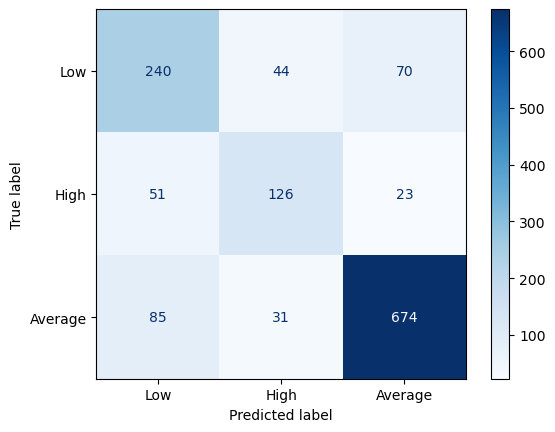

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred_bagging)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

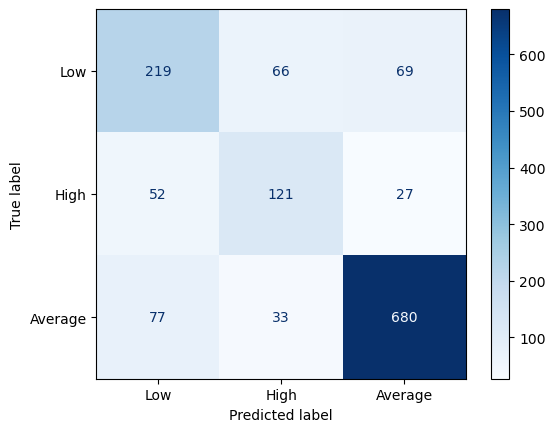

In [11]:
conf_matrix = confusion_matrix(y_test, y_pred_pasting)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Random Forest

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
rf_accuracy = accuracy_score(y_test, y_pred_rf)
results['Random Forest'] = rf_accuracy
print(f'Accuracy del modelo de Random Forest: {rf_accuracy:.2f}')

Accuracy del modelo de Random Forest: 0.78


In [13]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

     Average       0.66      0.68      0.67       354
        High       0.60      0.59      0.60       200
         Low       0.87      0.86      0.87       790

    accuracy                           0.78      1344
   macro avg       0.71      0.71      0.71      1344
weighted avg       0.78      0.78      0.78      1344



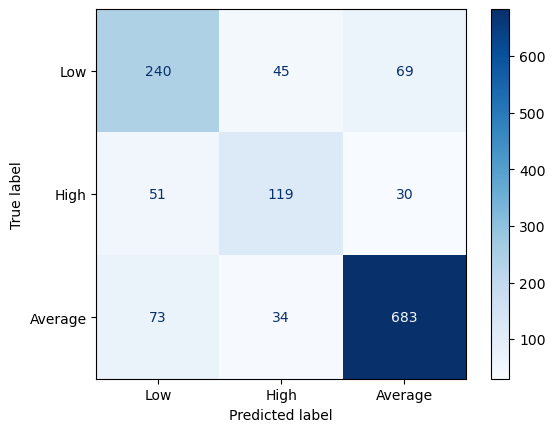

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Gradient Boosting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
gb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_gb = gb_model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)
results['Gradient Boosting'] = gb_accuracy
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Accuracy del modelo de Gradient Boosting: 0.82


In [16]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

     Average       0.65      0.89      0.75       354
        High       0.74      0.69      0.72       200
         Low       0.96      0.82      0.89       790

    accuracy                           0.82      1344
   macro avg       0.78      0.80      0.79      1344
weighted avg       0.85      0.82      0.83      1344



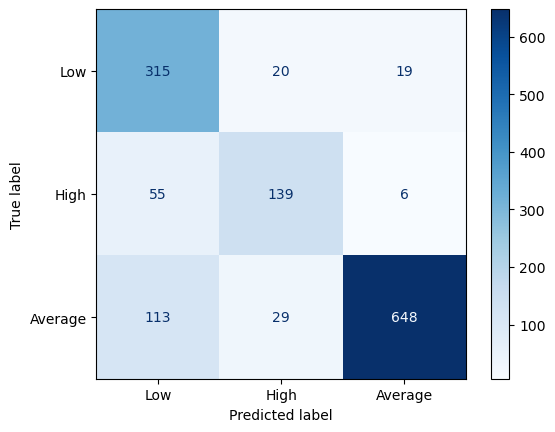

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred_gb)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Adaptive Boosting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de AdaBoost
# Usaremos un árbol de decisión como clasificador base
ada_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), 
                                n_estimators=100, 
                                random_state=42)

# Entrenar el modelo
ada_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_ada = ada_model.predict(X_test)

# Evaluar el modelo
ada_accuracy = accuracy_score(y_test, y_pred_ada)
results["Adaptative Boosting"] = ada_accuracy
print(f'Accuracy del modelo de AdaBoost: {ada_accuracy:.2f}')

Accuracy del modelo de AdaBoost: 0.82


In [19]:
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

     Average       0.66      0.88      0.75       354
        High       0.72      0.66      0.69       200
         Low       0.95      0.83      0.88       790

    accuracy                           0.82      1344
   macro avg       0.78      0.79      0.77      1344
weighted avg       0.84      0.82      0.82      1344



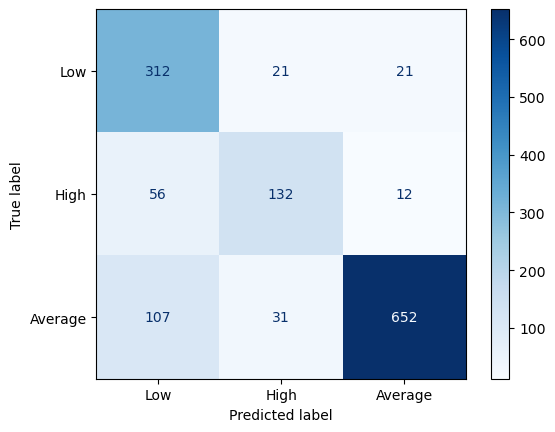

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred_ada)

# Obtener las etiquetas únicas
unique_labels = target_series.unique()  # O usa df_target['target'].unique()

# Mostramos la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_labels)
disp.plot(cmap='Blues')

## Results

In [21]:
results_df = pd.DataFrame(results.items(), columns=['Modelo', 'Precisión'])
results_df.sort_values(by='Precisión', ascending=False, inplace=True)

# Mostrar los resultados
print("Resultados de los Modelos:")
print(results_df)

# Determinar y mostrar el mejor modelo
best_model = results_df.iloc[0]
print(f"\nEl mejor modelo es: {best_model['Modelo']} con una precisión de: {best_model['Precisión']:.2f}")

Resultados de los Modelos:
                Modelo  Precisión
3    Gradient Boosting   0.819940
4  Adaptative Boosting   0.815476
2        Random Forest   0.775298
1  Bagging and Pasting   0.758929
0                  KNN   0.744792

El mejor modelo es: Gradient Boosting con una precisión de: 0.82


In [22]:
y_test_sq = y_test.squeeze()

In [23]:
df_predicciones = pd.DataFrame({
    'Original': y_test_sq,
    'Bagging': y_pred_bagging,
    'Pasting': y_pred_pasting,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "Adaptative Boosting": y_pred_ada
})

df_predicciones.to_csv("../data/df_predicciones.csv")

Gradient Boosting con GridSearchCV

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de hiperparámetros
grid = {
    'n_estimators': [50, 100],  # Reducido de 150 a 100
    'learning_rate': [0.01, 0.1],  # Mantener solo los más relevantes
    'max_depth': [3, 4],  # Reducido de 5 a 4
    'min_samples_split': [2, 5],  # Mantener solo los más relevantes
    'min_samples_leaf': [1, 2]  # Mantener solo los más relevantes
}

# Ajustar el modelo usando GridSearchCV
model = GridSearchCV(estimator=gb_model, param_grid=grid, cv=5, scoring='accuracy')
model.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
y_pred_gb = model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)

# Almacenar resultados
results['Gradient Boosting'] = gb_accuracy

# Imprimir los resultados
print(f'Mejores parámetros encontrados: {model.best_params_}')
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Mejores parámetros encontrados: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy del modelo de Gradient Boosting: 0.82


Gardient Boosting con RandomizedSearchCV

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Crear el modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Definir el grid de hiperparámetros con un rango reducido
param_dist = {
    'n_estimators': [50, 100],  # Mantener solo 50 y 100
    'learning_rate': [0.01, 0.1],  # Mantener solo los más relevantes
    'max_depth': [3, 4],  # Reducido a 3 y 4
    'min_samples_split': [2, 5],  # Reducido a 2 y 5
    'min_samples_leaf': [1, 2]  # Reducido a 1 y 2
}

# Ajustar el modelo usando RandomizedSearchCV
model = RandomizedSearchCV(estimator=gb_model, param_distributions=param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones con el mejor modelo encontrado
y_pred_gb = model.predict(X_test)

# Evaluar el modelo
gb_accuracy = accuracy_score(y_test, y_pred_gb)

# Almacenar resultados
results['Gradient Boosting'] = gb_accuracy

# Imprimir los resultados
print(f'Mejores parámetros encontrados: {model.best_params_}')
print(f'Accuracy del modelo de Gradient Boosting: {gb_accuracy:.2f}')

Mejores parámetros encontrados: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
Accuracy del modelo de Gradient Boosting: 0.82
